## Load the Haystack pipeline from Amazon S3 and run inferences - Part 2
---

In this notebook, we will we load the haystack pipeline that is stored in S3 as a `yml` file. Once the haystack pipeline is loaded, we will run a series of questions against the pipeline and measure different metrics, such as latency, accuracy metrics, etc. 

In [1]:
# import libraries
import os
import json
import boto3
import pickle
import logging
import tempfile
import pandas as pd
import globals as g
from typing import List

In [2]:
!pip install -Uq haystack

In [3]:
# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

Now, we will load the pipeline from the s3 bucket where it was saved as a `yml` file, and then see the contents of the pipeline. We will then run a series of inference requests against the pipeline and measure latency and accuracy metrics

In [4]:
# Initialize the S3 client
s3_client = boto3.client('s3')

# Create temporary file and download pipeline
with tempfile.NamedTemporaryFile(mode='wb', suffix='.yml', delete=False) as tmp_file:
    # Download from the same location where we uploaded
    s3_client.download_fileobj(
        g.HAYSTACK_PIPELINE_BUCKET, 
        g.HAYSTACK_PIPELINE_KEY, 
        tmp_file
    )
    logger.info(f"Downloaded the haystack pipeline from {g.HAYSTACK_PIPELINE_BUCKET}/{g.HAYSTACK_PIPELINE_KEY} to {tmp_file.name}")
    tmp_file_path = tmp_file.name

[2024-11-15 10:12:35,245] p89542 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials
[2024-11-15 10:12:36,985] p89542 {2606389201.py:12} INFO - Downloaded the haystack pipeline from sagemaker-us-east-2-015469603702/pipelines/basic_rag_pipeline.yml to /var/folders/jy/g9mb5j5n6c11fgdj788p5rww0000gr/T/tmpzcl4cc9d.yml


In [9]:
from haystack import Pipeline
# Now we will load the pipeline from the temporary file path
with open(tmp_file_path, 'r') as file:
    loaded_pipeline = Pipeline.load(file)
    print(f"Loaded the haystack pipeline from {tmp_file_path}")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xae in position 83: invalid start byte

[2024-11-15 10:05:02,592] p87247 {1922383777.py:4} INFO - Loaded Pipeline Structure:


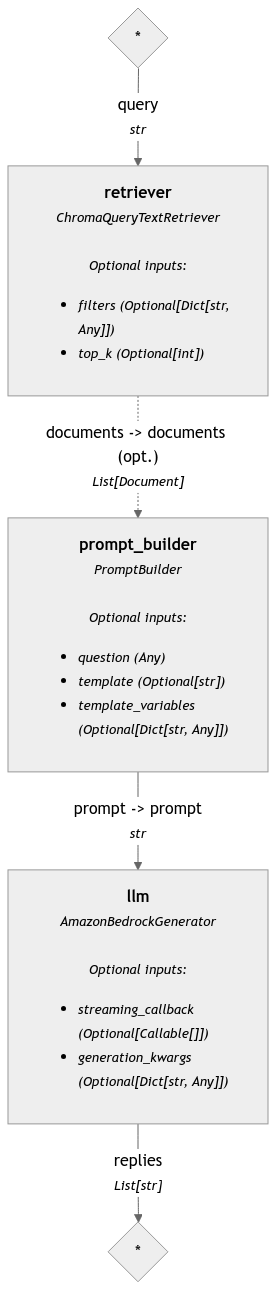

In [ ]:
# Now we will clean up the temporary file path and then see the contents of the pipeline
# that we had saved to s3
os.remove(tmp_file_path)
logger.info("Loaded Pipeline Structure:")
loaded_pipeline.show()

In [6]:
# load the documents stored earlier and get those documents in the doc store
import json
import shutil
from haystack_integrations.document_stores.chroma import ChromaDocumentStore

doc_store_key = "pipelines/document_store/chroma_store.zip"
chroma_persist_path = os.path.join(g.DATA_DIR, "chroma_store")

# Later, to download and restore the document store:
def load_document_store():
    # Download the zip file
    chroma_zip_path = os.path.join(g.DATA_DIR, "chroma_store.zip")
    s3_client.download_file(
        g.HAYSTACK_PIPELINE_BUCKET,
        doc_store_key,
        chroma_zip_path
    )
    
    # Remove existing chroma store if it exists
    if os.path.exists(chroma_persist_path):
        shutil.rmtree(chroma_persist_path)
    
    # Extract the zip file
    shutil.unpack_archive(chroma_zip_path, g.DATA_DIR, 'zip')
    
    # Clean up the zip file
    os.remove(chroma_zip_path)
    
    # Initialize ChromaDB with the restored data
    return ChromaDocumentStore(
        persist_path=chroma_persist_path,
        collection_name="documents",
        distance_function="cosine"
    )


In [7]:
load_document_store()

In [8]:
# Integrate the document store into your pipeline
retriever = loaded_pipeline.get_component('retriever')
retriever.document_store = load_document_store

NameError: name 'loaded_pipeline' is not defined

### Run inferences against the haystack pipeline using Amazon Bedrock
---

Now that we have loaded the pipeline from `s3`, we can run some inferences against this RAG pipeline. As we run inferences, we will measure latency and semantic similarity using the `SASEvaluator` module from haystack.

In [9]:
# Load the dataset that we processed in the first notebook
df = pd.read_csv(os.path.join(g.DATA_DIR, g.PUBMED_QA_CSV_FNAME)) 
df.head()

,instruction,context,response,category
0,Do cC and CXC chemokine levels in children wit...,Chemokines are a superfamily of small peptides...,Initial-phase serum levels of chemokines in pa...,closed_qa
1,Are sAH gene variants associated with obesity-...,The SAH gene locus has recently been proposed ...,We confirm recent evidence that the SAH locus ...,closed_qa
2,Do the functional anatomy of gaze-evoked tinni...,To identify neural sites associated with gaze-...,Patients with GET have plastic changes in mult...,closed_qa
3,Does neighborhood fast-food outlet exposure am...,Greater exposures to fast-food outlets and low...,These findings suggest that efforts to improve...,closed_qa
4,Does conditioned pain modulation predict exerc...,Conditioned pain modulation (CPM) is the conce...,"CPM was attenuated in older adults, as measure...",closed_qa


In [10]:
question: str = "What is a neurodegenerative disease? Give me examples"
document_store = loaded_pipeline.get_component('retriever')
# Directly query the document store to simulate what the BM25 retriever would retrieve
retrieved_docs = document_store.run(question)  # Use the question as the query

# Print the retrieved documents' content or metadata
print(f"Retrieved Documents: {retrieved_docs}")

# Now proceed with the full pipeline run to generate the final response
response = loaded_pipeline.run({
    "retriever": {"query": question},
    "prompt_builder": {"question": question}
})
print("LLM Response:")
print(response["llm"]["replies"][0])


[2024-11-15 09:46:19,048] p81842 {posthog.py:22} INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
[2024-11-15 09:46:20,406] p81842 {pipeline.py:75} INFO - Running component retriever
[2024-11-15 09:46:20,561] p81842 {pipeline.py:75} INFO - Running component prompt_builder
[2024-11-15 09:46:20,561] p81842 {pipeline.py:75} INFO - Running component llm


Retrieved Documents: {'documents': []}
LLM Response:
A neurodegenerative disease is a condition that involves the progressive loss of structure or function of neurons, leading to their death. Examples of neurodegenerative diseases include:

- Alzheimer's disease - a progressive brain disorder that leads to memory loss and cognitive decline.
- Parkinson's disease - a disorder that affects movement, causing tremors, stiffness, and difficulty with coordination.
- Huntington's disease - a genetic disorder that leads to un


### Measure the `SASEvaluation` score

Now, we will use Haystack's `SAS evaluator` to generate answers to the first 20 questions of the dataset. `SASEvaluator` will evaluate the answer predicted my the pipeline that we have loaded and then compare the semantic similarity to the ground truth provided in the dataset.

In [19]:
from haystack.components.evaluators import SASEvaluator

# Extract the questions and ground truth answers
test_queries = df['instruction'].tolist()
ground_truth_answers = df['response'].tolist()

# Initialize the SAS evaluator
sas_evaluator = SASEvaluator()
sas_evaluator.warm_up()

# Running the pipeline to get predictions
results = []
for question in test_queries:
    # Run the pipeline to get the predicted answer
    response = loaded_pipeline.run({
        "retriever": {"query": question},
        "prompt_builder": {"question": question}
    })
    predicted_answer = response["llm"]["replies"][0]
    results.append(predicted_answer)

# Evaluate the results using SAS evaluator
sas_evaluation = sas_evaluator.run(ground_truth_answers=ground_truth_answers, predicted_answers=results)

# Print the evaluation results
print("Semantic Answer Similarity Evaluation:")
print("Individual scores:", sas_evaluation["individual_scores"])
print("Overall mean SAS score:", sas_evaluation["score"])

# Optionally, print detailed results
print("\nDetailed Results:")
for i, (query, ground_truth, predicted) in enumerate(zip(test_queries, ground_truth_answers, results)):
    print(f"\nQuery {i+1}: {query}")
    print(f"Ground Truth: {ground_truth}")
    print(f"Predicted: {predicted}")
    print(f"SAS Score: {sas_evaluation['individual_scores'][i]}")


[2024-11-15 09:23:52,639] p69674 {SentenceTransformer.py:218} INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
[2024-11-15 09:23:57,774] p69674 {pipeline.py:75} INFO - Running component retriever
[2024-11-15 09:23:57,938] p69674 {pipeline.py:75} INFO - Running component prompt_builder
[2024-11-15 09:23:57,938] p69674 {pipeline.py:75} INFO - Running component llm
[2024-11-15 09:24:00,333] p69674 {pipeline.py:75} INFO - Running component retriever
[2024-11-15 09:24:00,437] p69674 {pipeline.py:75} INFO - Running component prompt_builder
[2024-11-15 09:24:00,438] p69674 {pipeline.py:75} INFO - Running component llm
[2024-11-15 09:24:00,448] p69674 {generator.py:182} WARNING - The prompt was truncated from 4513 tokens to 3996 tokens so that the prompt length and the answer length (100 tokens) fit within the model's max token limit (4096 tokens). Shorten the prompt or it will be cut off.
[2024-11-15 09:24:02,368] p69674 {pipeline.py:75} 

KeyboardInterrupt: 

In [ ]:
# save the evaluation metrics to a csv file
evaluation_data = []
for i, (query, ground_truth, predicted, score) in enumerate(zip(
    test_queries, 
    ground_truth_answers, 
    results, 
    sas_evaluation['individual_scores']
)):
    evaluation_data.append({
        'query_id': i + 1,
        'query': query,
        'ground_truth': ground_truth,
        'predicted_answer': predicted,
        'sas_score': score
    })
df_evaluation = pd.DataFrame(evaluation_data)

# Add the overall mean score as metadata
df_evaluation.attrs['mean_sas_score'] = sas_evaluation['score']

# Display the DataFrame
print("DataFrame Head:")
print(df_evaluation.head())
print(f"\nOverall Mean SAS Score: {df_evaluation.attrs['mean_sas_score']}")

# Save to CSV
csv_fpath_for_initial_eval = os.path.join(g.DATA_DIR, 'evaluation_results_before_dspy.csv')
df_evaluation.to_csv(csv_fpath_for_initial_eval, index=False)
print(f"\nResults saved to {csv_fpath_for_initial_eval}")


DataFrame Head:
   query_id                                              query  \
0         1  Do cC and CXC chemokine levels in children wit...   
1         2  Are sAH gene variants associated with obesity-...   
2         3  Do the functional anatomy of gaze-evoked tinni...   
3         4  Does neighborhood fast-food outlet exposure am...   
4         5  Does conditioned pain modulation predict exerc...   

                                        ground_truth  \
0  Initial-phase serum levels of chemokines in pa...   
1  We confirm recent evidence that the SAH locus ...   
2  Patients with GET have plastic changes in mult...   
3  These findings suggest that efforts to improve...   
4  CPM was attenuated in older adults, as measure...   

                                    predicted_answer  sas_score  
0  Based on the context provided, the key finding...   0.829714  
1  Here are the key points from the summarized re...   0.778862  
2  The key findings regarding the functional anat...